In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import matplotlib
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
import seaborn as sns

In [2]:
#input_spot = int(input('input_spot(int) : '))
#input_range = float(input('input_range(float) : '))
#input_eps = float(input('input_eps(float) : '))
#input_min = int(input('input_min(int) : '))
input_spot = 100
input_range = 20
input_eps = 0
input_min  = 0

# 랜덤 스팟 생성

In [3]:
def make_random_spot (input_spot, min_range, max_range, rseed=None):
    if(rseed != None):
        np.random.seed(rseed)
        
    var = ['X', 'Y']
    labels=['spot0']
    for i in range(0,input_spot-1):
        z = 'spot'+str(i+1)
        labels.append(z)
        
    X = (max_range - min_range) * np.random.random_sample([input_spot,2]) + min_range
    df = pd.DataFrame(X, columns = var, index = labels)
    
    return labels, X, df

In [4]:
labels, X, df = make_random_spot(input_spot, 0, 200, 111)

# 군집 전 랜덤 스팟 출력
삭제해도 괜찮지만 스팟 번호 확인, 전체 스팟의 초기 상태를 확인 할 수 있는 그래프임

'for i in range(0,input_spot):\n    if(i == 0):\n        str_val = "%s"%(labels[i])\n    else:\n        str_val = "0"\n    plt.text(X[i,0]+0.5, X[i,1], str_val, fontsize=9, color=\'black\',\n             horizontalalignment = \'left\', verticalalignment = \'top\')'

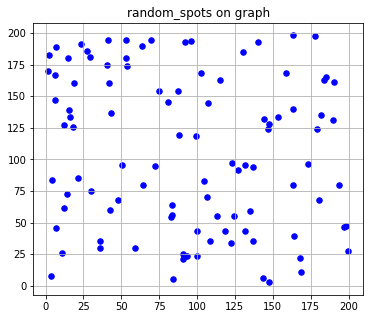

In [5]:
plt.figure(figsize=(13,5))
plt.subplot(121)
plt.title('random_spots on graph')
plt.scatter(X[:,0], X[:,1], c = 'blue', marker = 'o', s = 30)
plt.grid(True)

#점에 번호 붙여주는 기능↓ 나중에 주석 제거해서 사용가능
"""for i in range(0,input_spot):
    str_val = "(%.1f,%.1f)-%s"%(X[i,0], X[i,1], labels[i])
    plt.text(X[i,0]+0.5, X[i,1], str_val, fontsize=9, color='black',
             horizontalalignment = 'left', verticalalignment = 'center')"""

"""for i in range(0,input_spot):
    if(i == 0):
        str_val = "%s"%(labels[i])
    else:
        str_val = "0"
    plt.text(X[i,0]+0.5, X[i,1], str_val, fontsize=9, color='black',
             horizontalalignment = 'left', verticalalignment = 'top')"""

# DBSCAN 노이즈 계산

In [6]:
def make_DBSCAN (input_eps, input_min, df_dbscan, visualization = False):
    if((input_eps == 0) or (input_min == 0)):
        input_eps = 0.21
        input_min = 2
    
    scaler_ss = StandardScaler().fit(df_dbscan)
    x_scaled_ss = scaler_ss.transform(df_dbscan) 
    dbscan = DBSCAN(eps = input_eps, min_samples = input_min)
    clusters_ss = dbscan.fit_predict(x_scaled_ss)
    
    length = len(format(np.unique(clusters_ss)))
    
    # visualization = True 입력할때만 출력해주고 default는 출력 없음
    if(visualization == True):  
        df_np = np.hstack([df_dbscan, clusters_ss.reshape(-1, 1)]) # x_scaled_ss 오른쪽에 1열 붙이기
        
        for i in range(length):
            df_ft = df_np[df_np[:,2]==i, :]
            plt.scatter(df_ft[:, 0], df_ft[:, 1], cmap='PuOr', alpha = 0.8)
            
        # 노이즈 출력
        df_ft1 = df_np[df_np[:,2]==-1, :]
        plt.scatter(df_ft1[:, 0], df_ft1[:, 1], color = 'black')
        
        # ar은 노이즈로 분류된 점들의 첫 인덱스 번호를 가지고 있음
        ar = []
        for i in range(len(df)):
            if(df_np[i,2]==-1):
                ar.append(i)
        
        plt.grid(True)
        plt.show()
    
    return ar

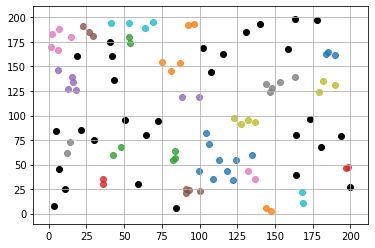

노이즈들 인덱스(ar) ->
 [2, 3, 10, 11, 12, 13, 17, 20, 27, 28, 29, 39, 41, 46, 49, 55, 56, 59, 66, 68, 72, 78, 79, 84, 85, 87, 89, 91, 99]


In [7]:
# dbscan에서 사용하기 위한 df의 값 복사본(데이터프레임 -> 리스트)을 함수 인자로 넣어줌
ar = make_DBSCAN(input_eps, input_min, df.values, True)
drop_len = len(ar)

print('노이즈들 인덱스(ar) ->\n',ar)

# 계산된 노이즈들을 군집에서 제외

In [8]:
def delete_noise (drop_df, ar ,drop_len):
    drop_list = np.array([])
    # drop_df = 노이즈 삭제 된 df
    # drop_list = 삭제 된 노이즈들 모인 list
    
    for i in range(drop_len):
        drop_list = np.append(drop_list, drop_df.values[ar[i]-i])
        sp = 'spot'+str(ar[i])
        drop_df = drop_df.drop([sp])
    
    drop_list = np.reshape(drop_list, (drop_len, 2))
    new_X = drop_df.values 
    # new_X = 마지막에서 좌표 출력할 때 사용될 랜덤 좌표계(노이즈 제거)
    
    new_labels = labels.copy()
    for i in range(len(ar)):
        a= 'spot'+str(ar[i])
        new_labels.remove(a)
    
    return new_X, drop_df, drop_list, new_labels

In [9]:
new_X, drop_df, drop_list, new_labels = delete_noise(df, ar, drop_len)

#=====================================================삭제요망
'''
in_df = drop_df.values[0]
drop_list.append(in_df)
sp = 'spot'+str(0)
drop_df = drop_df.drop([sp])

print(df)
print(drop_list)
print(drop_df)
'''

print(len(labels))
print(len(new_labels))

100
71


# 군집 + 덴드로그램 출력

In [10]:
def hierarchical_dendrogram(drop_df, new_labels, input_spot, drop_len, row_dist_print=False, a_print=False, dendrogram_print=False):
    
    distmatrix = pdist(drop_df, metric = 'euclidean')
    row_dist = pd.DataFrame(squareform(distmatrix), columns = new_labels, index = new_labels)
    
    row_clusters = linkage(distmatrix, method = 'average')
    
    a=pd.DataFrame(row_clusters,
            columns=['클러스터ID_1', '클러스터ID_2', '거리', '클러스터 멤버수'],
            index = ['클러스터 %d' %(i+input_spot-drop_len) for i in range(row_clusters.shape[0])])
    
    if(row_dist_print == True):
        print_col = row_dist.iloc[:5,:5]
        print(print_col)
    if(a_print == True):
        print(a[:5])
    if(dendrogram_print == True):
        plt.figure(figsize=(25,5))
        plt.subplot(121)
        plt.title('dendrogram')
        row_dendr = dendrogram(row_clusters, labels = new_labels)
        plt.tight_layout()
        plt.ylabel('euclide')
    
    return row_clusters

In [11]:
row_clusters = hierarchical_dendrogram(drop_df, new_labels, input_spot, drop_len, dendrogram_print = False)

# 군집별 넘버링 함수 + 출력

In [12]:
def cluster_numbering(row_clusters, input_range):
    # 넘버링에 필요한 재귀함수
    def found_num(Num, count, h):
        # ↓이미 넘버링 끝났는지 확인(끝났으면 0이므로 탈출, 아니면 지금 넘버링 시작이니 0으로 지정)
        if(iHave[Num][3]==0):
            return -1
        else:
            iHave[Num][3] = 0
            
        # 왼쪽 자식 확인
        if(iHave[Num][0] < h):
            cluster_done[int(iHave[Num][0])] = count
        else: #재귀
            left = int(iHave[Num][0]) - h
            found_num(left,count,h)
            
        # 오른쪽 자식 확인
        if(iHave[Num][1] < h):
            cluster_done[int(iHave[Num][1])] = count
        else: #재귀
            right = int(iHave[Num][1]) - h
            found_num(right,count,h)
        return
    
    rc_len = len(row_clusters)
    for i in range(0, rc_len):
        if(row_clusters[i][2] > float(input_range)):
            iHave = row_clusters[:i,:]
            num = i - 1 #몇 번의 합치기가 되었는지 저장
            break
            
    # 빈 리스트를 군집 개수 만큼 생성
    h = rc_len + 1
    cluster_done = [-1 for _ in range(h)]
    
    
    # 재귀 함수 호출
    count = 1
    for i in range(num, -1, -1):
        cycle = found_num(i, count, h)
        if (cycle != -1):
            count += 1
    
    return cluster_done

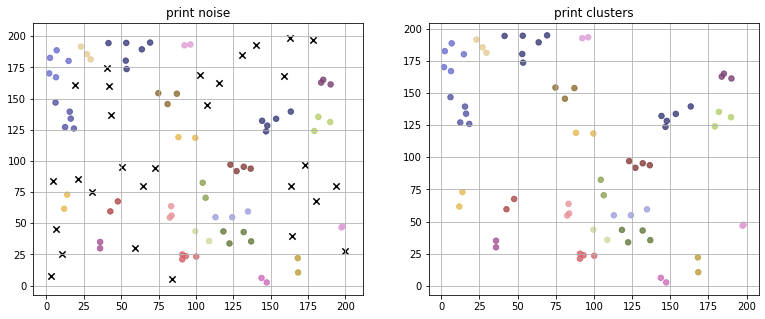

In [13]:
cluster_done = cluster_numbering(row_clusters.copy(), input_range)


plt.figure(figsize=(13,5))
plt.subplot(121)
plt.title('print noise')
plt.scatter(new_X[:,0], new_X[:,1], c=cluster_done, marker = 'o', s=30, cmap='tab20b', alpha = 0.8)
plt.scatter(drop_list[:, 0], drop_list[:, 1], marker = 'x', s=40, color = 'black')
plt.grid(True)


plt.subplot(122)
plt.title('print clusters')
plt.scatter(new_X[:,0], new_X[:,1], c=cluster_done, marker = 'o', s=30, cmap='tab20b', alpha = 0.8)
plt.grid(True)


plt.show()

# 군집별 중앙 값 검색(함수, 정렬, 중심찾기)

In [14]:
def marge_n_sort (input_spot, drop_list, drop_len, new_X, cluster_done):
    def quick_sort(centroid_X):
        def sort(low, high):
            if high <= low:
                return
            
            mid = partition(low, high)
            sort(low, mid - 1)
            sort(mid, high)
            
        def partition(low, high):
            pivot = centroid_X[(low + high) // 2][2]
            while low <= high:
                while centroid_X[low][2] < pivot:
                    #print(centroid_X[low][2], low, pivot)
                    low += 1
                while centroid_X[high][2] > pivot:
                    high -= 1
                if low <= high:
                    centroid_X[low][2], centroid_X[high][2] = centroid_X[high][2].copy(), centroid_X[low][2].copy()
                    centroid_X[low][1], centroid_X[high][1] = centroid_X[high][1].copy(), centroid_X[low][1].copy()
                    centroid_X[low][0], centroid_X[high][0] = centroid_X[high][0].copy(), centroid_X[low][0].copy()
                    low, high = low + 1, high - 1
            return low
        
        return sort(0, len(centroid_X) - 1)
    
    # 중앙 좌표 저장을 위한 numpy배열 생성(-1.0으로 모두 채움)
    centroid_X = np.full((input_spot - drop_len,3), -1.0)
    
    #스팟 좌표+소속 군집 번호
    for i in range(input_spot - drop_len):
        centroid_X[i][0] = new_X[i][0]
        centroid_X[i][1] = new_X[i][1]
        centroid_X[i][2] = cluster_done[i]
    
    quick_sort(centroid_X)
    
    #노이즈 좌표 + 노이즈 번호(노이즈는 모두 -1)
    for i in range(drop_len):
        centroid_X= np.append(centroid_X, (drop_list[i][0],drop_list[i][1],-1.0))
    
    centroid_X=np.reshape(centroid_X, (input_spot,3))
    
    return centroid_X

In [15]:
def make_centroid(centroid_X):
    # 중심 좌표 계산
    count = 1
    sumx = sumy = 0.0
    centroid = np.array([])
    shape = 0
    
    for i in range(len(centroid_X)):
        if(centroid_X[i][2] == -1):
            continue
        
        sumx += centroid_X[i][0]
        sumy += centroid_X[i][1]
        count += 1
        if(centroid_X[i][2] != centroid_X[i+1][2]):
            centroid = np.append(centroid, [sumx / float(count-1),sumy / float(count-1)])
            count = 1
            sumx = sumy = 0
            shape = int(centroid_X[i][2])
    
    centroid = np.reshape(centroid, (shape,2))
    
    return centroid

In [18]:
centroid_X = marge_n_sort (input_spot, drop_list, drop_len, new_X, cluster_done)
centroid = make_centroid(centroid_X)
#print(len(centroid))
#print(centroid_X)

# 최종 출력

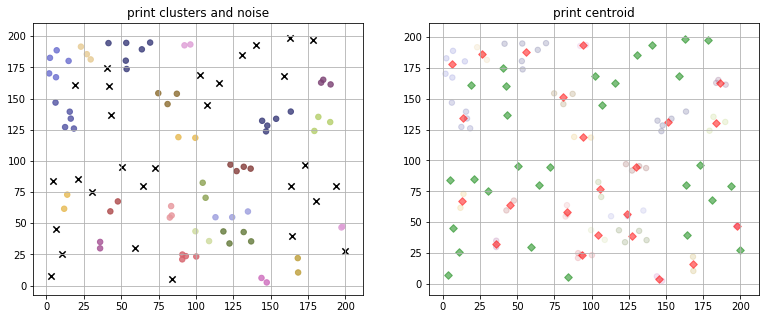

In [17]:
plt.figure(figsize=(13,5))
plt.subplot(121)
plt.title('print clusters and noise')

t=plt.scatter(new_X[:,0], new_X[:,1], c=cluster_done, marker = 'o', s=30, cmap='tab20b', alpha = 0.8)
plt.scatter(drop_list[:, 0], drop_list[:, 1], marker = 'x', s=40, color = 'black')

#plt.scatter(centroid[:,0], centroid[:,1], marker = 'D', s=40, color = 'magenta', alpha = 0.1)
plt.grid(True)



plt.subplot(122)
plt.title('print centroid')

plt.scatter(new_X[:,0], new_X[:,1], c=cluster_done, marker = 'o', s=30, cmap='tab20b', alpha = 0.2)
plt.scatter(drop_list[:, 0], drop_list[:, 1], marker = 'D', s=30, color = 'green', alpha = 0.5)

plt.scatter(centroid[:,0], centroid[:,1], marker = 'D', s=30, color = 'red', alpha = 0.5)
plt.grid(True)



plt.show()